# BDT - Boosted Decision Trees

In [67]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [68]:
from catboost.utils import get_gpu_device_count
print('I see %i GPU devices' % get_gpu_device_count())


I see 1 GPU devices


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import time

#import torch
#import tensorflow as tf
#from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from torch.utils.data import DataLoader, TensorDataset

import psutil
import GPUtil

from catboost import CatBoostClassifier, Pool

In [70]:
#--------- globals

# Need to see a large portion of the data before we can build a layer, for
# example half of data n_batches_per_layer =  NBATCH_FRAC * NUM_EXAMPLES / BATCH_SIZE
BATCH_SIZE = 1000

# Seed value
# Apparently you may use different seed values at each stage
SEED_VALUE= 10001
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED_VALUE)
# # 4. Set `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(SEED_VALUE)

In [71]:
import tensorflow as tf

FEATURES = 28
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
ds = tf.data.experimental.CsvDataset(gz, [tf.float32]*(FEATURES+1), compression_type="GZIP")

# Shuffle the dataset
BUFFER_SIZE = int(1e4)
ds = ds.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=True)

# Split features and labels
ds = ds.map(lambda *x: (tf.stack(x[1:]), x[0]))

# Calculate the size of the dataset
# Defining parameters for NN
N_VALIDATION = int(1e4)
N_TRAIN = int(1e5)
BUFFER_SIZE = int(1e5)
#BATCH_SIZE = 500
dataset_size = BUFFER_SIZE

# Split into training and test datasets (80-20 split)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

ds_train = ds.take(train_size)
ds_val = ds.skip(train_size)

# Batch the datasets
BATCH_SIZE = 1024
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
ds_train = ds_train.batch(BATCH_SIZE)
ds_val = ds_val.batch(BATCH_SIZE)

# Normalize the features within the dataset
def normalize(x, y):
    x = tf.cast(x, tf.float32)
    x = x / 255.0  # Adjust this based on your specific data range
    return x, y

ds_train = ds_train.map(normalize)
ds_val = ds_val.map(normalize)

# One-hot encode the labels
def one_hot_encode(x, y):
    y = tf.one_hot(tf.cast(y, tf.int32), depth=2)  # 2 classes: 0 and 1
    return x, y

ds_train = ds_train.map(one_hot_encode)
ds_val = ds_val.map(one_hot_encode)

# Prefetch to improve performance
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

print(ds_train)
print(ds_val)

# Convert to tensors
X_train, y_train = next(iter(ds_train))
X_val, y_val = next(iter(ds_val))

# Now X_train, y_train, X_val, and y_val are ready for use
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
X_train shape: (1024, 28), y_train shape: (1024, 2)
X_val shape: (1024, 28), y_val shape: (1024, 2)


In [72]:
import pandas as pd
# Load the CSV file
DIR = 'C:\\Programming\\Mafijski Praktikum\\#12 - Higgs\\'
data_path = DIR+'higgs\\HIGGS.csv.gz'
df = pd.read_csv(data_path, compression='gzip', header=None)

In [73]:
# Define the features dictionary
features = {
    1: [r'lepton $p_{T}^{\ell}$', 0],
    2: [r'lepton $\eta_{\ell}$', 0],
    3: [r'lepton $\phi$', 1],
    4: [r'missing energy $E_{\nu}^{miss}$', 0],
    5: [r'missing energy phi $\phi^{miss}$', 1],
    6: [r'jet 1 $p_{T}$', 0],
    7: [r'jet 1 $\eta$', 0],
    8: [r'jet 1 $\phi$', 1],
    9: [r'jet 1 $b$-tag', 2],
    10: [r'jet 2 $p_{T}$', 0],
    11: [r'jet 2 $\eta$', 0],
    12: [r'jet 2 $\phi$', 1],
    13: [r'jet 2 $b$-tag', 2],
    14: [r'jet 3 $p_{T}$', 0],
    15: [r'jet 3 $\eta$', 0],
    16: [r'jet 3 $\phi$', 1],
    17: [r'jet 3 $b$-tag', 2],
    18: [r'jet 4 $p_{T}$', 0],
    19: [r'jet 4 $\eta$', 0],
    20: [r'jet 4 $\phi$', 1],
    21: [r'jet 4 $b$-tag', 2],
    22: [r'$m_{jj}$', 0],
    23: [r'$m_{jjj}$', 0],
    24: [r'$m_{\ell\nu}$', 0],
    25: [r'$m_{j\ell\nu}$', 0],
    26: [r'$m_{bb}$', 0],
    27: [r'$m_{W\,bb}$', 0],
    28: [r'$m_{WW\,bb}$', 0]
}

# Split the features into continuous, uniform, and discrete
continuous_features = [key for key, value in features.items() if value[1] == 0]
uniform_features = [key for key, value in features.items() if value[1] == 1]
discrete_features = [key for key, value in features.items() if value[1] == 2]

In [74]:
FeaturesDict = {
    'class_label': np.float32,
    'jet_1_b-tag': np.float64,
    'jet_1_eta': np.float64,
    'jet_1_phi': np.float64,
    'jet_1_pt': np.float64,
    'jet_2_b-tag': np.float64,
    'jet_2_eta': np.float64,
    'jet_2_phi': np.float64,
    'jet_2_pt': np.float64,
    'jet_3_b-tag': np.float64,
    'jet_3_eta': np.float64,
    'jet_3_phi': np.float64,
    'jet_3_pt': np.float64,
    'jet_4_b-tag': np.float64,
    'jet_4_eta': np.float64,
    'jet_4_phi': np.float64,
    'jet_4_pt': np.float64,
    'lepton_eta': np.float64,
    'lepton_pT': np.float64,
    'lepton_phi': np.float64,
    'm_bb': np.float64,
    'm_jj': np.float64,
    'm_jjj': np.float64,
    'm_jlv': np.float64,
    'm_lv': np.float64,
    'm_wbb': np.float64,
    'm_wwbb': np.float64,
    'missing_energy_magnitude': np.float64,
    'missing_energy_phi': np.float64,
}

In [75]:
#print(df)
#print(df[0].head)
#print(df[1:].head)
print(df.T[:][1:].T.head)
print(df.head == df.T[:][1:].T.head)
print(df[0].head == df.T[0].T.head)

<bound method NDFrame.head of                 1         2         3         4         5         6   \
0         0.869293 -0.635082  0.225690  0.327470 -0.689993  0.754202   
1         0.907542  0.329147  0.359412  1.497970 -0.313010  1.095531   
2         0.798835  1.470639 -1.635975  0.453773  0.425629  1.104875   
3         1.344385 -0.876626  0.935913  1.992050  0.882454  1.786066   
4         1.105009  0.321356  1.522401  0.882808 -1.205349  0.681466   
...            ...       ...       ...       ...       ...       ...   
10999995  1.159912  1.013847  0.108615  1.495524 -0.537545  2.342396   
10999996  0.618388 -1.012982  1.110139  0.941023 -0.379199  1.004656   
10999997  0.700559  0.774251  1.520182  0.847112  0.211230  1.095531   
10999998  1.178030  0.117796 -1.276980  1.864457 -0.584370  0.998519   
10999999  0.464477 -0.337047  0.229019  0.954596 -0.868466  0.430004   

                7         8         9         10  ...        19        20  \
0        -0.248573 -1.092064

In [76]:
#-------- routines

def split_xy(df):
    #split features and labels from data 
    #prepare the data => normalizations !   

    # split 
    #data_y=rawdata['hlabel'] # labels only: 0.=bkg, 1.=sig
    #data_x=rawdata.drop(['hlabel'], axis=1) # features only
    # Extract labels
    data_y = df.iloc[:, 0]
    # Extract features
    data_x = df.iloc[:, 1:]
    
    #now prepare the data
    mu = data_x.mean()
    s = data_x.std()
    dmax = data_x.max()
    dmin = data_x.min()

    # normal/standard rescaling 
    #data_x = (data_x - mu)/s

    #scaling to [-1,1] range
    #data_x = -1. + 2.*(data_x - dmin)/(dmax-dmin)

    # scaling to [0,1] range
    #data_x = (data_x - dmin)/(dmax-dmin)


    return data_x, data_y

In [77]:
from sklearn.model_selection import train_test_split

X_trn, y_trn = split_xy(df) # training sample, should split a fraction for testing
X_train, X_val, y_train, y_val = train_test_split(X_trn, y_trn, test_size=0.1) # 10% split
#X_val, y_val = split_xy(hdata['valid']) # independent cross-valid sample

In [78]:
print(y_train)
print(X_train)

3847071     1.0
631451      1.0
5945702     0.0
8653110     1.0
4961933     1.0
           ... 
435325      0.0
330979      0.0
4983289     1.0
6911270     1.0
10413871    0.0
Name: 0, Length: 9900000, dtype: float64
                1         2         3         4         5         6   \
3847071   0.936092  0.148963 -1.718649  1.477774 -1.229120  1.180542   
631451    0.827018 -1.740536 -1.517789  1.329410 -0.814487  0.945112   
5945702   0.886862 -1.440554 -1.323033  2.658981 -1.404857  1.806128   
8653110   0.967935 -0.439314 -1.023963  1.004551 -1.557495  1.059254   
4961933   1.235494  0.896971 -1.106082  0.495942 -1.208640  0.810999   
...            ...       ...       ...       ...       ...       ...   
435325    0.818966 -0.964283  1.427520  1.913350  0.460205  1.023344   
330979    0.286409 -2.047337 -1.558849  1.388065  1.731063  0.649404   
4983289   0.681892 -2.222651 -1.253121  0.841537 -1.486759  0.270333   
6911270   0.830678  0.412909  1.379802  1.633823  1.018209  0.8

In [79]:
# ready the data for Catboost
#pool_train = Pool(data=X_train.to_numpy(),label=y_train.to_numpy())#,feature_names=data_fnames.tolist())
#pool_test = Pool(data=X_val.to_numpy(),label=y_val.to_numpy())#,feature_names=data_fnames.tolist())
pool_train = Pool(data=X_train, label=y_train)#,feature_names=data_fnames.tolist())
pool_test = Pool(data=X_val, label=y_val)#,feature_names=data_fnames.tolist())
#NaKratko .... ! 
# CatBoost parameters 
eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
task_type = 'CPU'  # if GPU else 'CPU'
max_number_of_trees = 100
#eval_metric = 'Accuracy'
bdt=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=max_number_of_trees,
    eval_metric=eval_metric,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    )   
#now train the model
bdt.fit(
        pool_train,
        early_stopping_rounds=20,
        #is early stopping relevant?
        eval_set=pool_test,
        plot=True # works when called through Ipython/jupyter
    )
print()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	test: 0.7144605	best: 0.7144605 (0)	total: 1.57s	remaining: 2m 35s
1:	test: 0.7359597	best: 0.7359597 (1)	total: 2.15s	remaining: 1m 45s
2:	test: 0.7488120	best: 0.7488120 (2)	total: 2.73s	remaining: 1m 28s
3:	test: 0.7581138	best: 0.7581138 (3)	total: 3.27s	remaining: 1m 18s
4:	test: 0.7653679	best: 0.7653679 (4)	total: 3.86s	remaining: 1m 13s
5:	test: 0.7709119	best: 0.7709119 (5)	total: 4.45s	remaining: 1m 9s
6:	test: 0.7745667	best: 0.7745667 (6)	total: 5.52s	remaining: 1m 13s
7:	test: 0.7774277	best: 0.7774277 (7)	total: 6.08s	remaining: 1m 9s
8:	test: 0.7793704	best: 0.7793704 (8)	total: 6.9s	remaining: 1m 9s
9:	test: 0.7815227	best: 0.7815227 (9)	total: 7.47s	remaining: 1m 7s
10:	test: 0.7837421	best: 0.7837421 (10)	total: 8.01s	remaining: 1m 4s
11:	test: 0.7850064	best: 0.7850064 (11)	total: 8.55s	remaining: 1m 2s
12:	test: 0.7867139	best: 0.7867139 (12)	total: 9.13s	remaining: 1m 1s
13:	test: 0.7879455	best: 0.7879455 (13)	total: 9.66s	remaining: 59

In [80]:
# ready the data for Catboost
#pool_train = Pool(data=X_train.to_numpy(),label=y_train.to_numpy())#,feature_names=data_fnames.tolist())
#pool_test = Pool(data=X_val.to_numpy(),label=y_val.to_numpy())#,feature_names=data_fnames.tolist())
pool_train = Pool(data=X_train, label=y_train)#,feature_names=data_fnames.tolist())
pool_test = Pool(data=X_val, label=y_val)#,feature_names=data_fnames.tolist())
#NaKratko .... ! 
# CatBoost parameters 
eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
additional_metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
task_type = 'GPU'  # if GPU else 'CPU'
max_number_of_trees = 100
bdt2=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=max_number_of_trees,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    )   
#now train the model
bdt2.fit(
        pool_train,
        early_stopping_rounds=20,
        #is early stopping relevant?
        eval_set=pool_test,
        plot=True # works when called through Ipython/jupyter
    )
print()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.159961


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7142456	best: 0.7142456 (0)	total: 185ms	remaining: 18.4s
1:	total: 321ms	remaining: 15.7s
2:	total: 447ms	remaining: 14.5s
3:	total: 556ms	remaining: 13.3s
4:	total: 666ms	remaining: 12.7s
5:	test: 0.7478272	best: 0.7478272 (5)	total: 796ms	remaining: 12.5s
6:	total: 901ms	remaining: 12s
7:	total: 1s	remaining: 11.5s
8:	total: 1.1s	remaining: 11.2s
9:	total: 1.2s	remaining: 10.8s
10:	test: 0.7661191	best: 0.7661191 (10)	total: 1.31s	remaining: 10.6s
11:	total: 1.4s	remaining: 10.3s
12:	total: 1.5s	remaining: 10s
13:	total: 1.59s	remaining: 9.77s
14:	total: 1.69s	remaining: 9.56s
15:	test: 0.7740223	best: 0.7740223 (15)	total: 1.81s	remaining: 9.49s
16:	total: 1.9s	remaining: 9.3s
17:	total: 2s	remaining: 9.11s
18:	total: 2.09s	remaining: 8.92s
19:	total: 2.19s	remaining: 8.76s
20:	test: 0.7799197	best: 0.7799197 (20)	total: 2.3s	remaining: 8.67s
21:	total: 2.4s	remaining: 8.51s
22:	total: 2.5s	remaining: 8.36s
23:	total: 2.6s	remaining: 8.23s
24:	total: 2.7s	remaining: 8.09

In [81]:
import seaborn as sns

# Plot loss (logloss) vs. epochs
def plot_loss_vs_epochs(models, names='default'):
    plt.figure(figsize=(10, 6))

    # Generate a color palette based on the number of models
    num_models = len(models)
    colors = sns.color_palette("hsv", num_models)  # Using a seaborn color palette
    for i, model in enumerate(models):
        if names!='default':
            label1 = f'{names[i]} - train'
            label2 = f'{names[i]} - validate'
        else:
            label1 = 'Training Loss'
            label2 = 'Validation Loss'
        plt.plot(model.get_evals_result()['learn']['Logloss'], color=colors[i], label=label1)
        plt.plot(model.get_evals_result()['validation']['Logloss'], linestyle="--", color=colors[i], label=label2)
    
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Logloss')
    plt.legend()
    plt.show()

# Example code for accuracy (replace Logloss with Accuracy if used)
def plot_accuracy_vs_epochs(models, names='default'):
    plt.figure(figsize=(10, 6))

    # Generate a color palette based on the number of models
    num_models = len(models)
    colors = sns.color_palette("hsv", num_models)  # Using a seaborn color palette
    for i, model in enumerate(models):
        if names!='default':
            label1 = f'{names[i]} - train'
            label2 = f'{names[i]} - validate'
        else:
            label1 = 'Training Accuracy'
            label2 = 'Validation Accuracy'
        plt.plot(model.get_evals_result()['learn']['Accuracy'], color=colors[i], label=label1)
        plt.plot(model.get_evals_result()['validation']['Accuracy'], linestyle="--", color=colors[i], label=label2)
    
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(models, pool_test, names='default'):
    plt.figure(figsize=(6, 6))
    

    for i, model in enumerate(models):
        # Get the predicted probabilities for the positive class
        y_prob = model.predict_proba(pool_test)[:, 1]

        # Get the true labels
        y_true = pool_test.get_label()

        # Calculate the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        # Calculate the AUC
        roc_auc = auc(fpr, tpr)
        #roc_auc = roc_auc_score(fpr, tpr)

        # Plotting the ROC Curve
        if names!='default':
            label1 = f'{names[i]} - AUC = {roc_auc:.4f}'
        else:
            label1 = f'ROC Curve (AUC = {roc_auc:.4f})'
        plt.plot(fpr, tpr, label=label1)
    
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def plot_roc_curve2(models, pool_test):
    plt.figure()
    for i, model in enumerate(models):
        bdt_model_history = model.get_evals_result()
        niter = np.arange(1, len(bdt_model_history['validation']['AUC'])+1)
        AUC_history = bdt_model_history['validation']['AUC']

        plt.plot(niter, AUC_history, label='Bdt Model Test')
    
    plt.title('Training history')
    plt.ylabel('Auc')
    plt.xlabel('# Trees')
    plt.legend()
    plt.show()

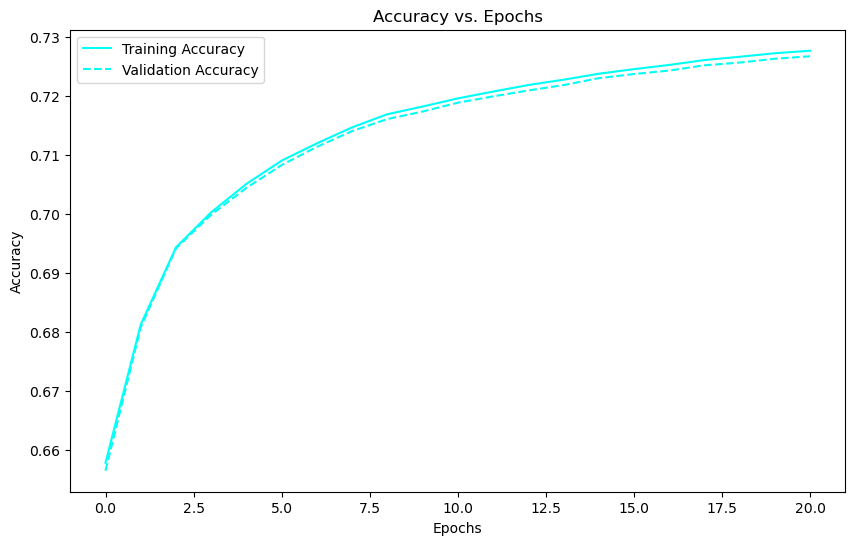

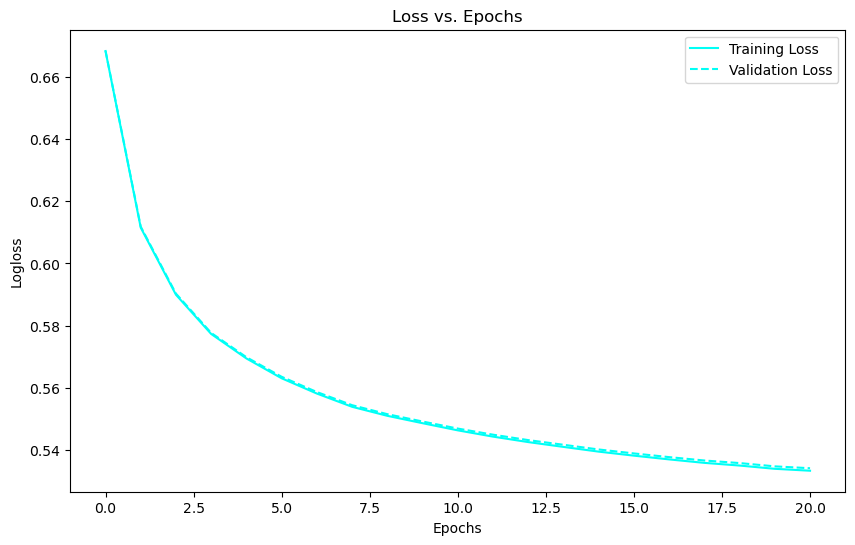

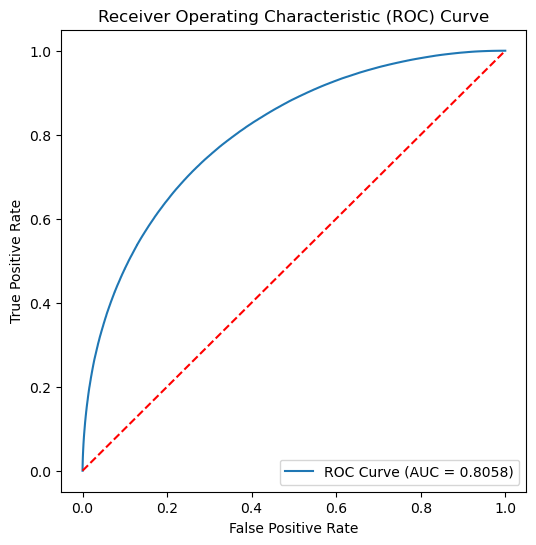

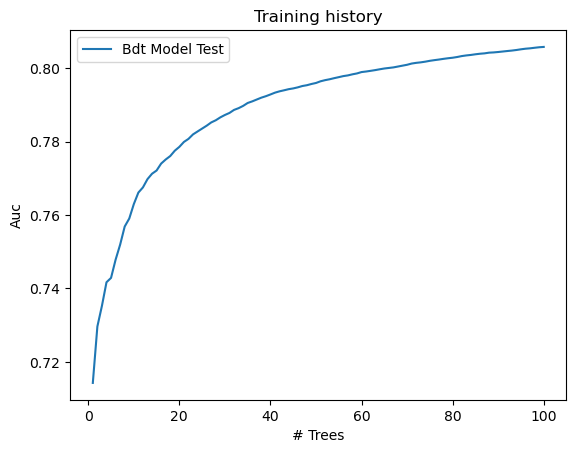

In [82]:
plot_accuracy_vs_epochs([bdt2])
plot_loss_vs_epochs([bdt2])
plot_roc_curve([bdt2], pool_test)
plot_roc_curve2([bdt2], pool_test)


In [83]:
def plot_score_histogram(model, pool_test):
    y_prob = model.predict_proba(pool_test)[:, 1]
    y_true = pool_test.get_label()

    # Separate scores based on the true labels
    positive_scores = y_prob[y_true == 1]
    negative_scores = y_prob[y_true == 0]

    plt.figure(figsize=(10, 6))
    plt.hist(positive_scores, bins=30, alpha=0.7, color='blue', label='Positive Class')
    plt.hist(negative_scores, bins=30, alpha=0.7, color='red', label='Negative Class')
    plt.title('Score Histogram')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Call the function
#plot_score_histogram(bdt2, pool_test)

## High Level vs Low Level

In [84]:
continuous_features = [key for key, value in features.items() if value[1] == 0]
X_train_low = X_train.iloc[:, :22]
X_val_low = X_val.iloc[:, :22]
X_train_high = X_train.iloc[:, 22:]
X_val_high = X_val.iloc[:, 22:]

print(X_train_low.shape)

(9900000, 22)


In [85]:
pool_train = Pool(data=X_train, label=y_train)#,feature_names=data_fnames.tolist())
pool_test = Pool(data=X_val, label=y_val)#,feature_names=data_fnames.tolist())
pool_train_low = Pool(data=X_train_low, label=y_train)
pool_test_low = Pool(data=X_val_low, label=y_val)
pool_train_high = Pool(data=X_train_high, label=y_train)
pool_test_high = Pool(data=X_val_high, label=y_val)

# CatBoost parameters 
eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
additional_metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
task_type = 'GPU'  # if GPU else 'CPU'

bdt_low=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=max_number_of_trees,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    )

bdt_high=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=max_number_of_trees,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    ) 

bdt_all=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=max_number_of_trees,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    ) 

#now train the model
bdt_low.fit(
        pool_train_low,
        early_stopping_rounds=20,
        #is early stopping relevant?
        eval_set=pool_test_low,
        plot=True # works when called through Ipython/jupyter
    )
print()
bdt_high.fit(
        pool_train_high,
        early_stopping_rounds=20,
        #is early stopping relevant?
        eval_set=pool_test_high,
        plot=True # works when called through Ipython/jupyter
    )
print()
bdt_all.fit(
        pool_train,
        early_stopping_rounds=20,
        #is early stopping relevant?
        eval_set=pool_test,
        plot=True # works when called through Ipython/jupyter
    )
print()



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.159961


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6104449	best: 0.6104449 (0)	total: 327ms	remaining: 32.3s
1:	total: 451ms	remaining: 22.1s
2:	total: 560ms	remaining: 18.1s
3:	total: 691ms	remaining: 16.6s
4:	total: 806ms	remaining: 15.3s
5:	test: 0.6471794	best: 0.6471794 (5)	total: 928ms	remaining: 14.5s
6:	total: 1.03s	remaining: 13.7s
7:	total: 1.13s	remaining: 13s
8:	total: 1.23s	remaining: 12.4s
9:	total: 1.34s	remaining: 12s
10:	test: 0.6595596	best: 0.6595596 (10)	total: 1.46s	remaining: 11.8s
11:	total: 1.55s	remaining: 11.3s
12:	total: 1.64s	remaining: 11s
13:	total: 1.73s	remaining: 10.6s
14:	total: 1.83s	remaining: 10.4s
15:	test: 0.6652713	best: 0.6652713 (15)	total: 1.95s	remaining: 10.2s
16:	total: 2.03s	remaining: 9.92s
17:	total: 2.13s	remaining: 9.68s
18:	total: 2.23s	remaining: 9.48s
19:	total: 2.32s	remaining: 9.29s
20:	test: 0.6738376	best: 0.6738376 (20)	total: 2.44s	remaining: 9.17s
21:	total: 2.53s	remaining: 8.98s
22:	total: 2.63s	remaining: 8.79s
23:	total: 2.71s	remaining: 8.6s
24:	total: 2.81s	r

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.159961


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7142453	best: 0.7142453 (0)	total: 113ms	remaining: 11.1s
1:	total: 193ms	remaining: 9.46s
2:	total: 269ms	remaining: 8.7s
3:	total: 339ms	remaining: 8.13s
4:	total: 399ms	remaining: 7.59s
5:	test: 0.7345415	best: 0.7345415 (5)	total: 481ms	remaining: 7.54s
6:	total: 539ms	remaining: 7.16s
7:	total: 598ms	remaining: 6.88s
8:	total: 657ms	remaining: 6.64s
9:	total: 716ms	remaining: 6.44s
10:	test: 0.7480582	best: 0.7480582 (10)	total: 794ms	remaining: 6.42s
11:	total: 853ms	remaining: 6.26s
12:	total: 910ms	remaining: 6.09s
13:	total: 968ms	remaining: 5.95s
14:	total: 1.03s	remaining: 5.82s
15:	test: 0.7532865	best: 0.7532865 (15)	total: 1.1s	remaining: 5.8s
16:	total: 1.16s	remaining: 5.67s
17:	total: 1.22s	remaining: 5.56s
18:	total: 1.28s	remaining: 5.46s
19:	total: 1.34s	remaining: 5.35s
20:	test: 0.7569305	best: 0.7569305 (20)	total: 1.42s	remaining: 5.33s
21:	total: 1.47s	remaining: 5.23s
22:	total: 1.53s	remaining: 5.13s
23:	total: 1.59s	remaining: 5.04s
24:	total: 1.6

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.159961


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7142456	best: 0.7142456 (0)	total: 157ms	remaining: 15.5s
1:	total: 283ms	remaining: 13.9s
2:	total: 409ms	remaining: 13.2s
3:	total: 545ms	remaining: 13.1s
4:	total: 655ms	remaining: 12.4s
5:	test: 0.7478276	best: 0.7478276 (5)	total: 786ms	remaining: 12.3s
6:	total: 891ms	remaining: 11.8s
7:	total: 996ms	remaining: 11.5s
8:	total: 1.1s	remaining: 11.1s
9:	total: 1.19s	remaining: 10.7s
10:	test: 0.7661190	best: 0.7661190 (10)	total: 1.3s	remaining: 10.5s
11:	total: 1.4s	remaining: 10.2s
12:	total: 1.49s	remaining: 9.96s
13:	total: 1.58s	remaining: 9.7s
14:	total: 1.68s	remaining: 9.49s
15:	test: 0.7740917	best: 0.7740917 (15)	total: 1.79s	remaining: 9.4s
16:	total: 1.89s	remaining: 9.21s
17:	total: 1.97s	remaining: 8.98s
18:	total: 2.07s	remaining: 8.81s
19:	total: 2.16s	remaining: 8.65s
20:	test: 0.7797429	best: 0.7797429 (20)	total: 2.27s	remaining: 8.56s
21:	total: 2.37s	remaining: 8.39s
22:	total: 2.46s	remaining: 8.24s
23:	total: 2.56s	remaining: 8.11s
24:	total: 2.65s

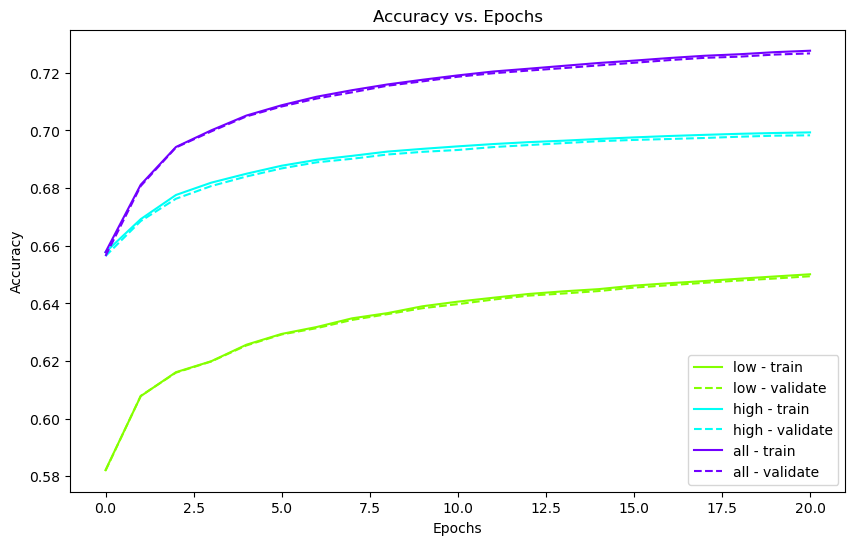

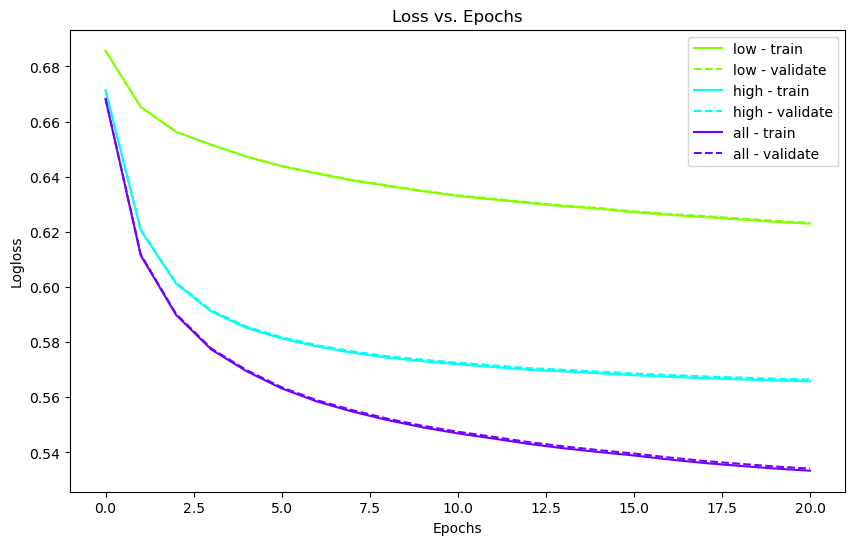

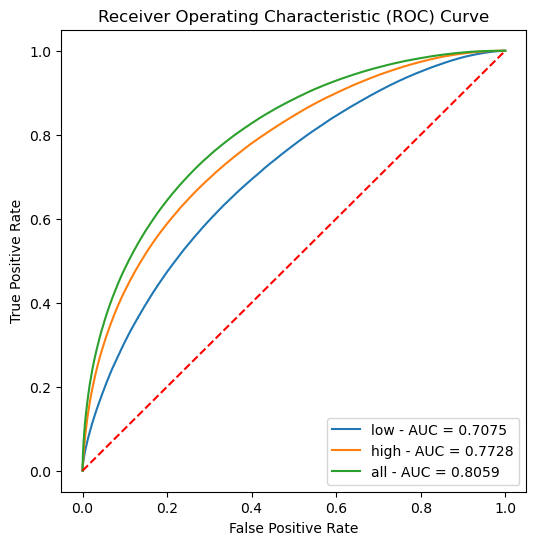

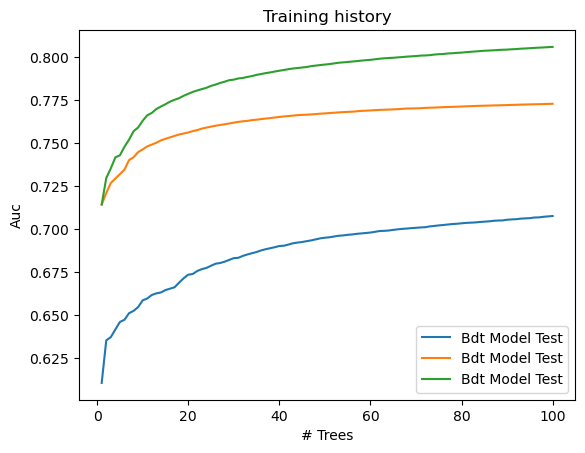

In [86]:
plot_accuracy_vs_epochs([bdt_low, bdt_high, bdt_all], names=['low', 'high', 'all'])
plot_loss_vs_epochs([bdt_low, bdt_high, bdt_all], names=['low', 'high', 'all'])
plot_roc_curve([bdt_low, bdt_high, bdt_all], pool_test, names=['low', 'high', 'all'])
plot_roc_curve2([bdt_low, bdt_high, bdt_all], pool_test)

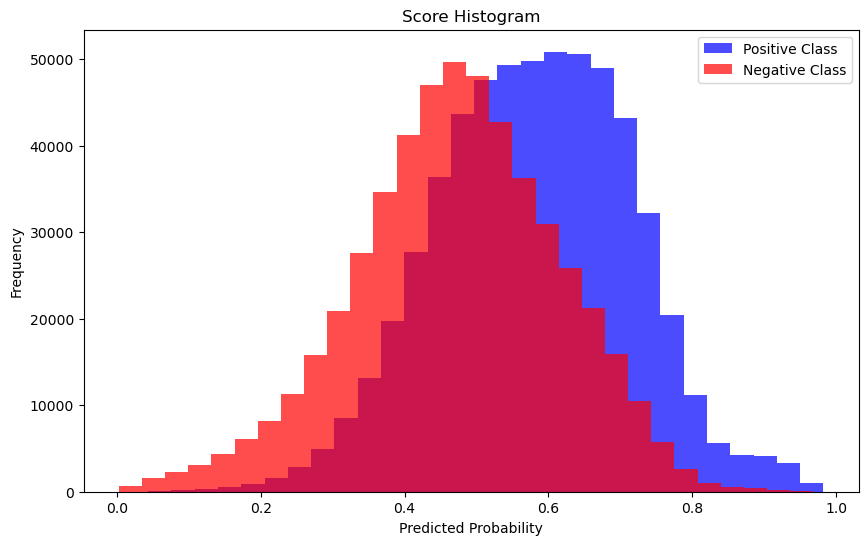

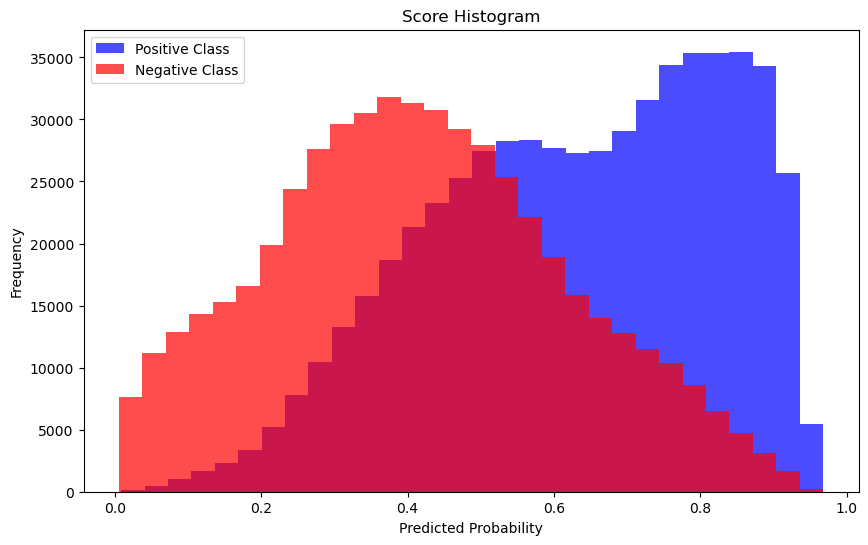

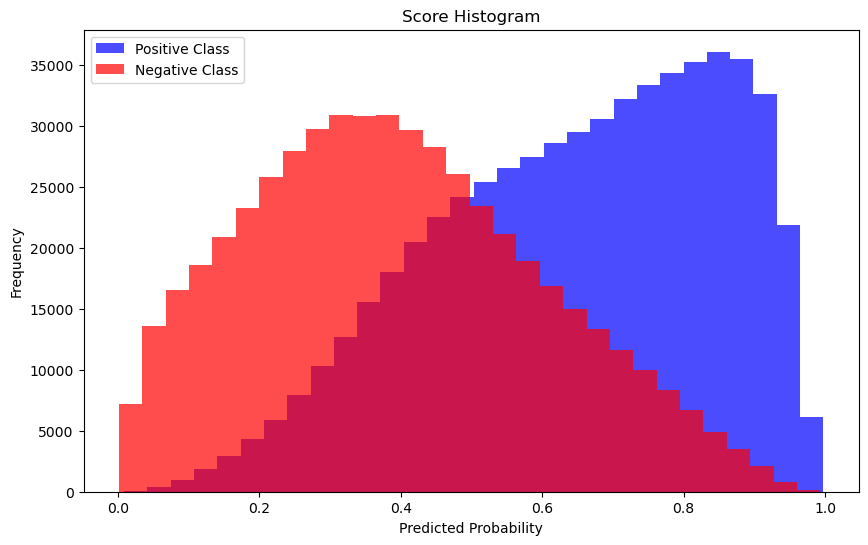

In [87]:
plot_score_histogram(bdt_low, pool_test_low)
plot_score_histogram(bdt_high, pool_test)
plot_score_histogram(bdt_all, pool_test)

## 10 ; 100 ; 1000 Trees, call it a jungle

In [88]:
pool_train = Pool(data=X_train, label=y_train)#,feature_names=data_fnames.tolist())
pool_test = Pool(data=X_val, label=y_val)#,feature_names=data_fnames.tolist())

# CatBoost parameters 
eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
additional_metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
task_type = 'GPU'  # if GPU else 'CPU'

bdt10=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=10,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    ) 
bdt100=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=100,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    ) 
bdt1000=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=1000,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=6,
    use_best_model=False,
    random_seed=SEED_VALUE,
    ) 

#now train the model
bdt10.fit(
        pool_train,
        early_stopping_rounds=20,
        eval_set=pool_test,
        plot=True 
    )
print()
bdt100.fit(
        pool_train,
        early_stopping_rounds=20,
        eval_set=pool_test,
        plot=True 
    )
print()
bdt1000.fit(
        pool_train,
        early_stopping_rounds=20,
        eval_set=pool_test,
        plot=True 
    )
print()



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7142456	best: 0.7142456 (0)	total: 164ms	remaining: 1.48s
1:	total: 297ms	remaining: 1.19s
2:	total: 410ms	remaining: 957ms
3:	total: 539ms	remaining: 809ms
4:	total: 647ms	remaining: 647ms
5:	test: 0.7702989	best: 0.7702989 (5)	total: 773ms	remaining: 516ms
6:	total: 881ms	remaining: 378ms
7:	total: 990ms	remaining: 247ms
8:	total: 1.09s	remaining: 121ms
9:	test: 0.7826648	best: 0.7826648 (9)	total: 1.2s	remaining: 0us
bestTest = 0.7826648057
bestIteration = 9



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.159961


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7142456	best: 0.7142456 (0)	total: 159ms	remaining: 15.7s
1:	total: 284ms	remaining: 13.9s
2:	total: 411ms	remaining: 13.3s
3:	total: 549ms	remaining: 13.2s
4:	total: 660ms	remaining: 12.5s
5:	test: 0.7478272	best: 0.7478272 (5)	total: 792ms	remaining: 12.4s
6:	total: 897ms	remaining: 11.9s
7:	total: 1s	remaining: 11.5s
8:	total: 1.11s	remaining: 11.2s
9:	total: 1.2s	remaining: 10.8s
10:	test: 0.7661192	best: 0.7661192 (10)	total: 1.31s	remaining: 10.6s
11:	total: 1.4s	remaining: 10.3s
12:	total: 1.5s	remaining: 10s
13:	total: 1.59s	remaining: 9.76s
14:	total: 1.68s	remaining: 9.54s
15:	test: 0.7740228	best: 0.7740228 (15)	total: 1.8s	remaining: 9.44s
16:	total: 1.89s	remaining: 9.25s
17:	total: 1.99s	remaining: 9.06s
18:	total: 2.08s	remaining: 8.86s
19:	total: 2.17s	remaining: 8.7s
20:	test: 0.7799200	best: 0.7799200 (20)	total: 2.29s	remaining: 8.61s
21:	total: 2.38s	remaining: 8.45s
22:	total: 2.48s	remaining: 8.3s
23:	total: 2.58s	remaining: 8.16s
24:	total: 2.67s	remai

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.020324


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7142456	best: 0.7142456 (0)	total: 228ms	remaining: 3m 47s
1:	total: 342ms	remaining: 2m 50s
2:	total: 449ms	remaining: 2m 29s
3:	total: 556ms	remaining: 2m 18s
4:	total: 662ms	remaining: 2m 11s
5:	test: 0.7267859	best: 0.7267859 (5)	total: 789ms	remaining: 2m 10s
6:	total: 885ms	remaining: 2m 5s
7:	total: 981ms	remaining: 2m 1s
8:	total: 1.08s	remaining: 1m 58s
9:	total: 1.17s	remaining: 1m 55s
10:	test: 0.7313462	best: 0.7313462 (10)	total: 1.29s	remaining: 1m 55s
11:	total: 1.38s	remaining: 1m 53s
12:	total: 1.48s	remaining: 1m 52s
13:	total: 1.58s	remaining: 1m 51s
14:	total: 1.67s	remaining: 1m 49s
15:	test: 0.7345791	best: 0.7345791 (15)	total: 1.79s	remaining: 1m 50s
16:	total: 1.89s	remaining: 1m 49s
17:	total: 1.98s	remaining: 1m 48s
18:	total: 2.08s	remaining: 1m 47s
19:	total: 2.17s	remaining: 1m 46s
20:	test: 0.7379342	best: 0.7379342 (20)	total: 2.29s	remaining: 1m 46s
21:	total: 2.38s	remaining: 1m 45s
22:	total: 2.48s	remaining: 1m 45s
23:	total: 2.57s	remaini

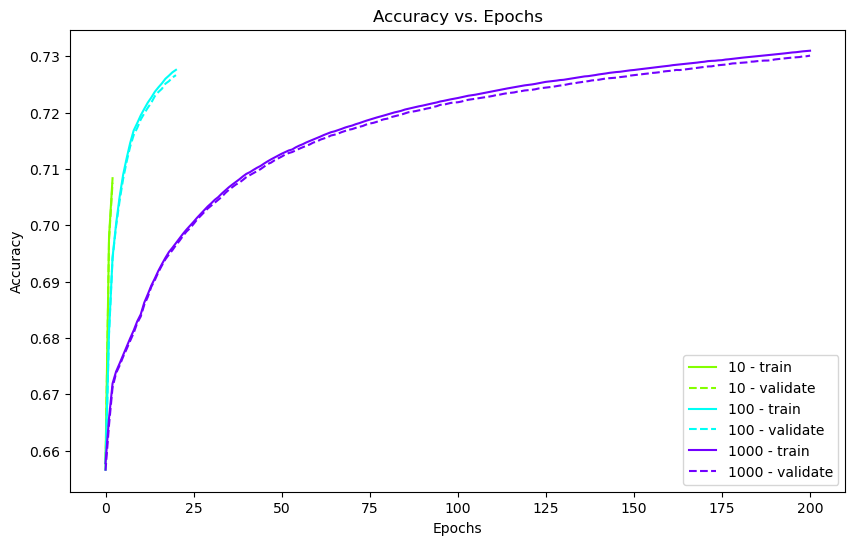

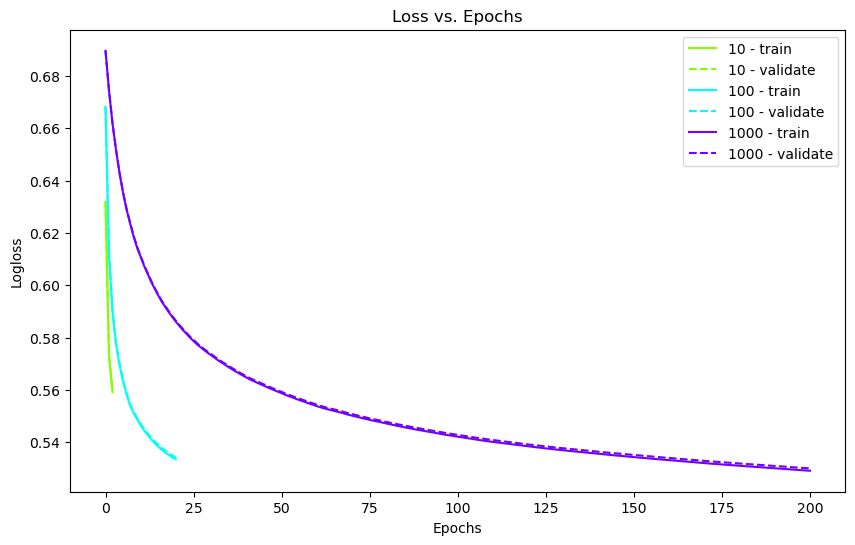

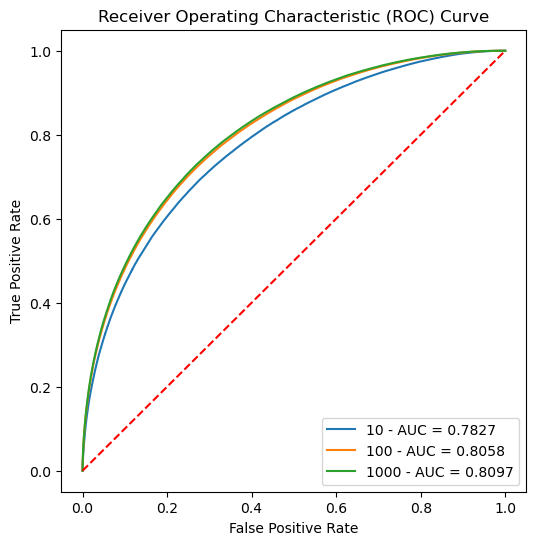

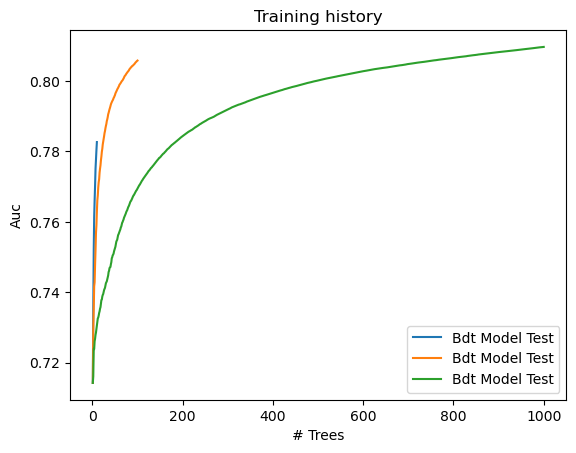

In [89]:
plot_accuracy_vs_epochs([bdt10, bdt100, bdt1000], names=['10', '100', '1000'])
plot_loss_vs_epochs([bdt10, bdt100, bdt1000], names=['10', '100', '1000'])
plot_roc_curve([bdt10, bdt100, bdt1000], pool_test, names=['10', '100', '1000'])
plot_roc_curve2([bdt10, bdt100, bdt1000], pool_test)

## Optimal

In [90]:
extracted_strings = list(FeaturesDict.keys())[1:]
print(extracted_strings)

['jet_1_b-tag', 'jet_1_eta', 'jet_1_phi', 'jet_1_pt', 'jet_2_b-tag', 'jet_2_eta', 'jet_2_phi', 'jet_2_pt', 'jet_3_b-tag', 'jet_3_eta', 'jet_3_phi', 'jet_3_pt', 'jet_4_b-tag', 'jet_4_eta', 'jet_4_phi', 'jet_4_pt', 'lepton_eta', 'lepton_pT', 'lepton_phi', 'm_bb', 'm_jj', 'm_jjj', 'm_jlv', 'm_lv', 'm_wbb', 'm_wwbb', 'missing_energy_magnitude', 'missing_energy_phi']


In [91]:
# Extract the feature names
extracted_strings = [features[key][0] for key in range(1, 29)]
extracted_strings = list(FeaturesDict.keys())[1:]
print(extracted_strings)
# Identify categorical features based on the type value of 2 in the features dictionary
#cat_features_index = [idx for idx, val in features.items()]# if idx != 0]# if val[1] == 2]
#print(cat_features_index)
"""
# Identify categorical features (assuming all features are numerical if type is np.float64)
is_categorical = {feature: dtype == np.float64 for feature, dtype in FeaturesDict.items()}
cat_features = [i for i, (feature, is_cat) in enumerate(is_categorical.items()) if is_cat]
cat_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
print(cat_features)

# Handle missing values and ensure categorical features are strings
for feature in X_train.columns[cat_features]:
    X_train[feature] = X_train[feature].astype(str).fillna('missing')
    X_val[feature] = X_val[feature].astype(str).fillna('missing')
print(X_train)"""
is_categorical = {feature: dtype != np.float64 for feature, dtype in FeaturesDict.items()}
cat_features = [i for i, (feature, is_cat) in enumerate(is_categorical.items()) if is_cat]

['jet_1_b-tag', 'jet_1_eta', 'jet_1_phi', 'jet_1_pt', 'jet_2_b-tag', 'jet_2_eta', 'jet_2_phi', 'jet_2_pt', 'jet_3_b-tag', 'jet_3_eta', 'jet_3_phi', 'jet_3_pt', 'jet_4_b-tag', 'jet_4_eta', 'jet_4_phi', 'jet_4_pt', 'lepton_eta', 'lepton_pT', 'lepton_phi', 'm_bb', 'm_jj', 'm_jjj', 'm_jlv', 'm_lv', 'm_wbb', 'm_wwbb', 'missing_energy_magnitude', 'missing_energy_phi']


In [92]:
#pool_train = Pool(data=X_train, label=y_train,feature_names=X_train.columns.tolist())
#pool_test = Pool(data=X_val, label=y_val,feature_names=X_train.columns.tolist())

#pool_train = Pool(data=X_train, label=y_train, cat_features=cat_features_index, feature_names=extracted_strings)
#pool_test = Pool(data=X_val, label=y_val, cat_features=cat_features_index, feature_names=extracted_strings)

# Create the Pool object for training and validation
#pool_train = Pool(data=X_train, label=y_train, cat_features=cat_features, feature_names=list(X_train.columns))
#pool_test = Pool(data=X_val, label=y_val, cat_features=cat_features, feature_names=list(X_val.columns))
#pool_train = Pool(data=X_train, label=y_train, cat_features=cat_features, feature_names=extracted_strings)
#pool_test = Pool(data=X_val, label=y_val, cat_features=cat_features, feature_names=extracted_strings)
pool_train = Pool(data=X_train, label=y_train, feature_names=extracted_strings)
pool_test = Pool(data=X_val, label=y_val, feature_names=extracted_strings)

eval_metric = 'AUC' # see https://catboost.ai/docs/concepts/loss-functions-classification.html
additional_metrics = ['Accuracy', 'F1', 'Precision', 'Recall']
task_type = 'GPU'  # if GPU else 'CPU'
max_number_of_trees = 100
bdt_opt=CatBoostClassifier(
    verbose=True,
    task_type=task_type,
    loss_function='Logloss', # see values same as in eval_metric, e.g. CrossEntropy, Logloss is default
    #loss_function='CrossEntropy', 
    iterations=max_number_of_trees,
    eval_metric=eval_metric,
    custom_metric=additional_metrics,
    #learning_rate=0.01,
    max_depth=12,
    use_best_model=True,
    random_seed=SEED_VALUE,
    )   

#now train the model
bdt_opt.fit(
        pool_train,
        early_stopping_rounds=20,
        eval_set=pool_test,
        plot=True # works when called through Ipython/jupyter
    )
print()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.084508


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7495393	best: 0.7495393 (0)	total: 411ms	remaining: 40.7s
1:	total: 654ms	remaining: 32.1s
2:	total: 886ms	remaining: 28.6s
3:	total: 1.1s	remaining: 26.4s
4:	total: 1.31s	remaining: 24.8s
5:	test: 0.7716942	best: 0.7716942 (5)	total: 1.54s	remaining: 24.1s
6:	total: 1.74s	remaining: 23.2s
7:	total: 1.96s	remaining: 22.5s
8:	total: 2.17s	remaining: 22s
9:	total: 2.39s	remaining: 21.5s
10:	test: 0.7808870	best: 0.7808870 (10)	total: 2.61s	remaining: 21.2s
11:	total: 2.81s	remaining: 20.6s
12:	total: 3.02s	remaining: 20.2s
13:	total: 3.23s	remaining: 19.8s
14:	total: 3.43s	remaining: 19.4s
15:	test: 0.7871112	best: 0.7871112 (15)	total: 3.66s	remaining: 19.2s
16:	total: 3.86s	remaining: 18.8s
17:	total: 4.07s	remaining: 18.5s
18:	total: 4.27s	remaining: 18.2s
19:	total: 4.47s	remaining: 17.9s
20:	test: 0.7918788	best: 0.7918788 (20)	total: 4.71s	remaining: 17.7s
21:	total: 4.92s	remaining: 17.4s
22:	total: 5.12s	remaining: 17.1s
23:	total: 5.33s	remaining: 16.9s
24:	total: 5.5

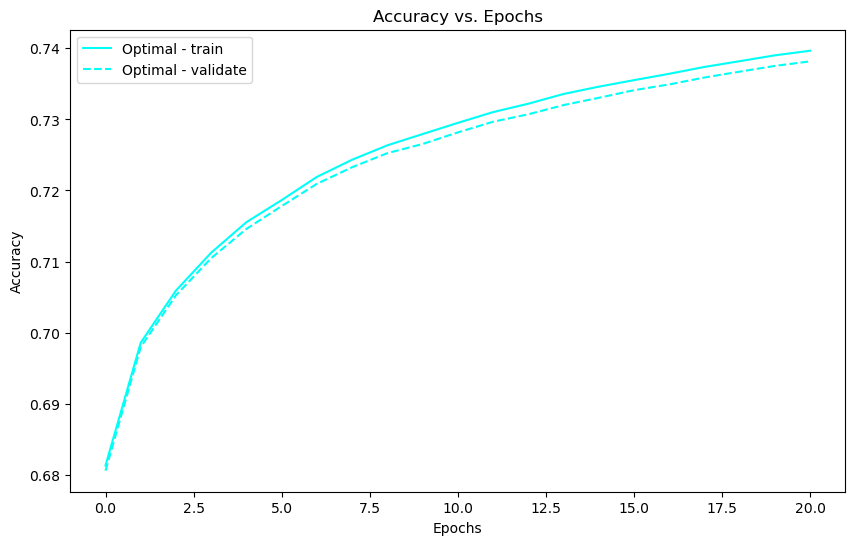

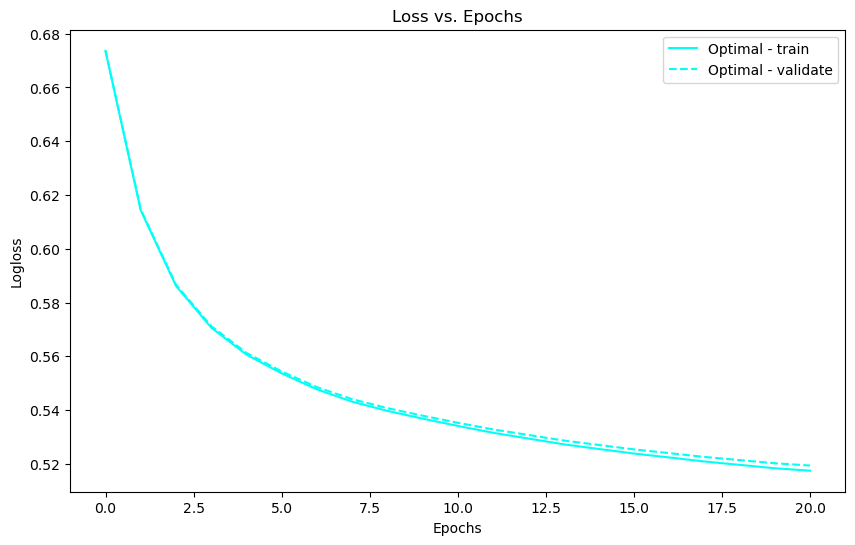

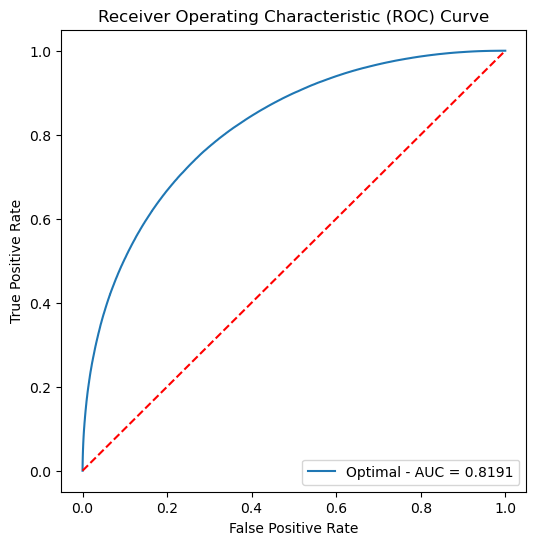

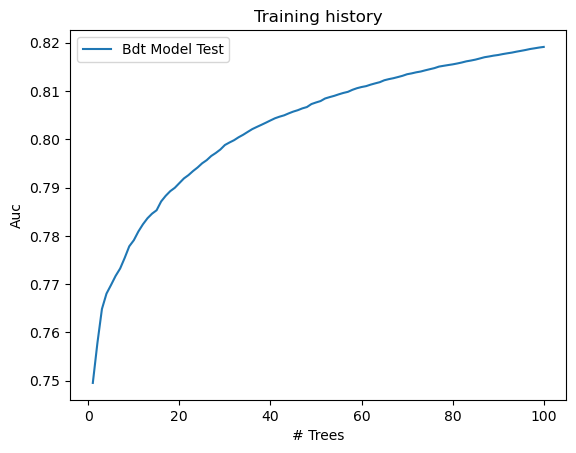

In [94]:
plot_accuracy_vs_epochs([bdt_opt], names=['Optimal'])
plot_loss_vs_epochs([bdt_opt], names=['Optimal'])
plot_roc_curve([bdt_opt], pool_test, names=['Optimal'])
plot_roc_curve2([bdt_opt], pool_test)

In [93]:
# Plot the first tree in the model
bdt_opt.plot_tree(
    tree_idx=0,
    pool=pool_test,  # Pool used to visualize the tree
)
